# Exploratory Data Analysis

# Intro

This notebook is for exploratory data analysis of the data provided in the OTTO – Multi-Objective Recommender System project. In this notebook, we will be understanding the properties of the dataset. After understanding the data, in other notebooks we will be benchmarking various machine learning approaches for building a recommendation system.

# Objective

The data description on the OTTO competition page on Kaggle mentions that for each `session`, we have the `ts` (time stamps), `aid` (article IDs), and `type` (event type). The `type` can be one of `clicks`, `carts`, and `orders`. The EDA in this notebook investigates the following in the training data:

1. Quantification: # of rows, counts of `session`, count of `aid`
2. Understanding User Behavior: count of unique `aid` per session (i.e. how many unique items the user is interested in), `clicks` per `session` (how much does the user browse), `carts` per `session` (how many items are added to cart), `orders` per `session` (are there multiple orders in a single session)
3. Understanding Articles: `clicks` per `aid` (i.e. most to least clicked articles), `carts` per `aid` (which items are added to cart the most), `orders` per `aid` (are there specific articles which trigger the ordering), co-occurence of `aid` (how likely are two `aid` to co-occur in a session), transition matrix of `aid` (which article will be clicked on next)
5. Understanding Time Spent: calculate difference of last and first `ts` as time elapsed, time elapsed per `session` (how much tiime does a user spend per session), time elapsed per `aid` (how much time is spent per article), time elapsed on an `aid` right before `carts` (how much time is spent on an article before adding to cart), time elapsed on `aid` added to cart and those `aid` not added to cart

Note: The training data set is very large (~13M sessions and ~217M events). Analyzing such large data for exploratory analysis only using the resources available on Kaggle would be quite challening. Therefore, we are using sample size of 150K. Techniques for performing exploratory data analyis on large datasets includes using the `multiprocessing` or `dask` packages. Another alternative would be, `pyspark`.

Note: As we proceed through the exploratory analysis in this notebook, our findings are summarized for each objective in cells beginning with **Findings**.

# References

1. https://www.kaggle.com/code/edwardcrookenden/otto-getting-started-eda-baseline
2. https://www.kaggle.com/code/inversion/read-a-chunk-of-jsonl

# Virtual Env Freezing

#### Freezing the virtual environment on Kaggle
By documenting our environment, we want to ensures reproduceability.

In [1]:
!pip freeze > requirements.txt

# Reading Data

In [2]:
import numpy as np
import pandas as pd

import seaborn as sns
from datetime import timedelta

import os

# Apply the default theme
sns.set_theme()

data_path = r"/kaggle/input/otto-recommender-system/"

In [3]:
import warnings
warnings.filterwarnings("ignore", "use_inf_as_na")

In [4]:
# Load in a sample to a pandas df

sample_size = 150000

chunks = pd.read_json(data_path+'/train.jsonl', lines=True, chunksize = sample_size)

for c in chunks:
    sample_train_df = c
    break

In [5]:
sample_train_df.head(3)

,session,events
0,0,"[{'aid': 1517085, 'ts': 1659304800025, 'type':..."
1,1,"[{'aid': 424964, 'ts': 1659304800025, 'type': ..."
2,2,"[{'aid': 763743, 'ts': 1659304800038, 'type': ..."


In [6]:
sample_train_df.loc[0, "events"][0:3]

[{'aid': 1517085, 'ts': 1659304800025, 'type': 'clicks'},
 {'aid': 1563459, 'ts': 1659304904511, 'type': 'clicks'},
 {'aid': 1309446, 'ts': 1659367439426, 'type': 'clicks'}]

In [7]:
# Expand the 'events' column into individual rows
expanded_df = sample_train_df.explode('events').reset_index(drop=True)
expanded_df.head(3)

,session,events
0,0,"{'aid': 1517085, 'ts': 1659304800025, 'type': ..."
1,0,"{'aid': 1563459, 'ts': 1659304904511, 'type': ..."
2,0,"{'aid': 1309446, 'ts': 1659367439426, 'type': ..."


In [8]:
# Convert the dictionaries in 'events' column into separate columns
expanded_df[["aid", "ts", "type"]] = pd.json_normalize(expanded_df['events'])
expanded_df = expanded_df.drop('events', axis=1)
expanded_df.head(3)

,session,aid,ts,type
0,0,1517085,1659304800025,clicks
1,0,1563459,1659304904511,clicks
2,0,1309446,1659367439426,clicks


In [9]:
expanded_df.shape

(7841827, 4)

# Quantification

### # of rows

In [10]:
# %%time 

# num_lines = sum(1 for line in open(data_path+'/train.jsonl'))
# print(f'number of lines in train: {num_lines:,}')

In [11]:
print(f'number of sessions in the sample of training data: {len(expanded_df["session"].unique()):,}')

number of sessions in the sample of training data: 150,000


In [12]:
print(f'number of aid in the sample of training data: {len(expanded_df["aid"].unique()):,}')

number of aid in the sample of training data: 830,140


# Understanding User Behavior

### Count of unique aid per session

How many unique items the user is interested in?

In [13]:
naid_per_session = (
    expanded_df
    .groupby(["session"])
    ["aid"]
    .nunique()
    .reset_index()
)

In [14]:
naid_per_session["aid"].min(), naid_per_session["aid"].max()

(1, 460)

In [15]:
naid_per_session["aid"].value_counts()[0:20]

aid
2     15381
3     10858
4      8256
5      6743
6      5704
1      5332
7      4869
8      4443
9      3838
10     3478
11     3172
12     2979
13     2792
14     2473
15     2344
16     2291
17     2075
18     1935
19     1768
20     1707
Name: count, dtype: int64

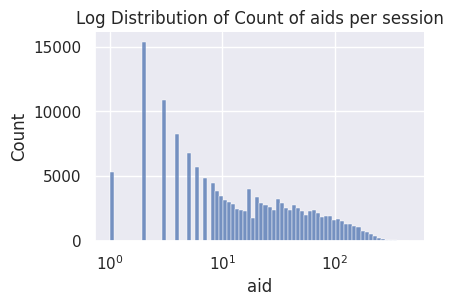

In [16]:
(
    sns.displot(data=naid_per_session, x='aid', log_scale=True, height=3, aspect=1.5)
    .set(
        title='Log Distribution of Count of aids per session',
    )
)

**Findings**
1. The least number of products looked at by the user is 1. The most is 460.
2. Most users look at 2 products, followed by 3, 4, 5 and 6 products. 
3. The next highest number of products viewed by the user is 1 product.

### Clicks per session

How much does the user browse?

In [17]:
nclicks_per_session = (
    expanded_df
    .loc[expanded_df["type"]=="clicks"]
    .groupby(["session"])
    ["type"]
    .count()
    .reset_index()
)

In [18]:
nclicks_per_session["type"].min(), nclicks_per_session["type"].max()

(2, 493)

In [19]:
nclicks_per_session["type"].value_counts()[0:20]

type
2     13509
3      9750
4      7612
5      6149
6      5194
7      4409
8      4167
9      3567
10     3235
11     2937
12     2641
13     2617
14     2460
15     2191
16     2115
17     1954
18     1811
20     1770
19     1759
21     1583
Name: count, dtype: int64

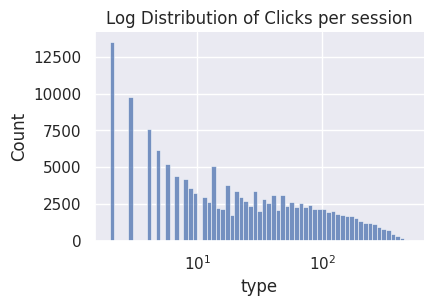

In [20]:
(
    sns.displot(data=nclicks_per_session, x='type', log_scale=True, height=3, aspect=1.5)
    .set(
        title='Log Distribution of Clicks per session',
    )
)

**Findings**:
1. Minimum number of clicks in a session is 2, maximum is 493.
2. Most user click at least twice.
3. The distrubtion is very similar to that of the number of articles.

### Carts per session 

How many items are added to cart?

In [21]:
ncarts_per_session = (
    expanded_df
    .loc[expanded_df["type"]=="carts"]
    .groupby(["session"])
    ["type"]
    .count()
    .reset_index()
)

In [22]:
ncarts_per_session.head(3)

,session,type
0,0,17
1,1,8
2,2,1


In [23]:
ncarts_per_session["type"].min(), ncarts_per_session["type"].max()

(1, 399)

In [24]:
ncarts_per_session["type"].value_counts()[0:20]

type
1     15668
2      9568
3      6759
4      5195
5      4167
6      3507
7      2861
8      2429
9      2110
10     1878
11     1579
12     1449
13     1216
14     1125
15      997
16      873
17      768
18      744
19      618
20      580
Name: count, dtype: int64

In [25]:
(
    ncarts_per_session["type"].value_counts()[0:3].sum()
    /
    ncarts_per_session["type"].value_counts()[4:].sum()
)

0.956216377764495

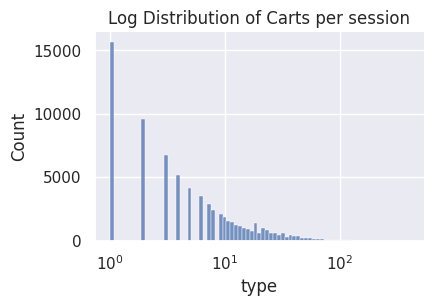

In [26]:
(
    sns.displot(data=ncarts_per_session, x='type', log_scale=True, height=3, aspect=1.5)
    .set(
        title='Log Distribution of Carts per session',
    )
)

**Findings**:
1. Most users add 1 article to card, followed by 2 and 3 articles.
2. The max number of items added to card are 399.
3. The number of users adding 1 and 2 or 3 articles to card is about the same as the users adding 4 or more articles to cart.